In [1]:
#Calculating the escape fraction Epsilon as a function of Black Hole Mass
import matplotlib
#matplotlib.use('Agg')
import yt
import numpy as np
import sys
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import glob
from yt.utilities.physical_constants import mh, mp, me, G, kboltz, pi
from math import pi
from yt.units.yt_array import YTQuantity, YTArray




In [2]:
def BondiRadius(M_BH, cs, v):
    R = G * M_BH / (cs*cs + v*v)
    return R


In [3]:
#Merger Rate of Heavy Seeds
#
R_0 = YTQuantity(500, 'pc') #Setting the radius of the inital black hole radius from centre
Num_HeavySeeds = 20             #masses > 1000 Msolar

#Just test with this seed mass
M_BH = YTQuantity(1e4, 'msun')   #Peak heavy seed mass spectrum 10^4
#N_tot = YTQuantity(1000, 'kpc**-3') #to induce mergers we need a large density
#GalaxySize = YTQuantity(1, 'kpc')
#GalaxyVolume = 4 * np.pi * np.power(GalaxySize, 3.0)/3.0

#The background density is the total density (DM + gas + stars)
#For LeoI the total mass inside 1 kpc ~ 8 x 10^7 Msolar (i.e. pretty dense) so the density is 
#approximately 2e7 Msun/kpc^3. However, dynamical friction isn't as effective as this and 
#this has been realised when observing systems like Fornax etc. 
#Changing this value has a big impact on the dynamical friction timescale however and is the 
#single biggest driver. For LeoI the below value is probably ok I tink?

background_density = YTQuantity(2e7, 'Msun/kpc**3')
Temp = YTQuantity(10000, 'K')    #can vary (lower) this but 10000 K is reasonable
Gamma = 5.0/3.0
Mu = 1.22

tau_hubble = YTQuantity(13.8, 'Gyr') #age of Universe
f = 1e-4                          # fraction of volume filled with dense gas
soundspeed2 = Gamma*kboltz*Temp/(Mu*mh)
soundspeed = YTQuantity(np.sqrt(soundspeed2).d, 'cm/s')
cs = soundspeed
v_bh = cs
R_bondi = BondiRadius(M_BH.in_units('g'), cs, v_bh)

def MergerRate(M_BH, v_bh, cs, N_tot):
    sigma = BondiRadius(M_BH.in_units('g'), cs, v_bh) * BondiRadius(M_BH.in_units('g'), cs, v_bh) * np.pi
    merger_rate = 1e-2 * N_tot * sigma * v_bh
    return merger_rate

def NewRadius(R_0, t, t_df):
    return(R_0 * np.exp(-t/(2*t_df)))

#1. What is the sinking time for a heavy seed?

t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')

print("Dynamical Friction Time = ", t_df)

print("New Radius = ", NewRadius(R_0, tau_hubble, t_df))

new_radius = NewRadius(R_0, tau_hubble, t_df)
N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

print("N_tot number density = ", N_tot)

print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
print("Merger Rate = ", MergerRate(M_BH, v_bh, cs, N_tot).to("Gyr**-1"))

N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(M_BH, v_bh, cs, N_tot) * tau_hubble

#Total number of mergers in a Hubble Time
print("Total Number of Mergers in a Hubble Time = ", N_mm)
N_mm =  min(Num_HeavySeeds, N_mm)
epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))

print("epsilon = ", epsilon)

Dynamical Friction Time =  9.553999205029124 Gyr
New Radius =  242.83870218008317 pc
N_tot number density =  1.3966136621239888e-06 pc**(-3)
Ntot in Galaxy =  20.0 dimensionless
Merger Rate =  1.7344286676363182e-05 1/Gyr
Total Number of Mergers in a Hubble Time =  0.004787023122676235 dimensionless
epsilon =  0.9997606488438662 dimensionless


masses.sum = 3.250426e+06 Msolar


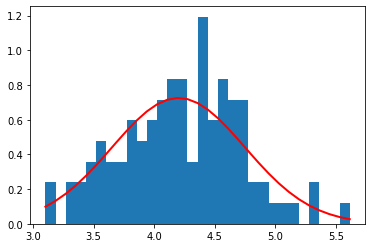

bins =  [3.10138108 3.52019091 3.93900074 4.35781057 4.7766204  5.19543023
 5.61424006]
count =  [ 9. 19. 28. 34.  7.  3.]
BH Masses =  [  1262.93522593   3312.76712123   8689.6190511   22793.47641712
  59788.87729402 156830.39228688 411377.04967941]


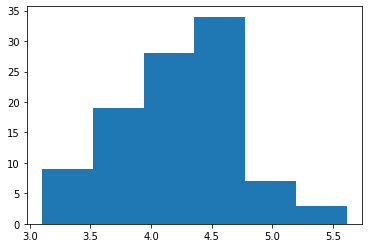

In [4]:
#Ok let's test the model
#First up we need a normal distribution of heavy seed masses
np.random.seed(131180)

#Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
mu, sigma = 4.2, 0.55 # mean and standard deviation
#mu, sigma = 4.9, 0.35 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)


masses = np.power(10, s)
#print("masses = ", masses)
print("masses.sum = %e Msolar" % (masses.sum()))
count, bins, ignored = plt.hist(s, 30, density=True)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')

plt.show()

#To do this I recreate the above histogram without normalising
#and I divide into 5 bins
count, bins, ignored = plt.hist(s, 6, density=False)



print("bins = ", bins)
print("count = ", count)
print("BH Masses = ", np.power(10.0, bins))

In [5]:
#Now calculate the dynamical friction time for each mass bin
#
massbins = np.power(10, bins[1::])
DyTime = []
print("bins = ", massbins)
for M_BH, N_tot in zip(massbins, count):
    M_BH = YTQuantity(M_BH, 'Msun')
    print("M_BH = ", M_BH)
    t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
    print("t_df = ", t_df)
    print("")
    DyTime.append(t_df)
    
 

bins =  [  3312.76712123   8689.6190511   22793.47641712  59788.87729402
 156830.39228688 411377.04967941]
M_BH =  3312.767121232004 Msun
t_df =  28.83993608785888 Gyr

M_BH =  8689.619051098756 Msun
t_df =  10.994727327915568 Gyr

M_BH =  22793.476417121892 Msun
t_df =  4.191549823375077 Gyr

M_BH =  59788.87729401652 Msun
t_df =  1.5979559472318872 Gyr

M_BH =  156830.39228687956 Msun
t_df =  0.609193094891494 Gyr

M_BH =  411377.0496794058 Msun
t_df =  0.23224434159549598 Gyr



In [6]:
#Calculate the number of mergers for each mass bin in a hubble time
Epsilon = []
for M_BH, Num_HeavySeeds, t_df in zip(massbins, count, DyTime):
    new_radius = NewRadius(R_0, tau_hubble, t_df)
    N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

    #print("N_tot number density = ", N_tot)
    
    #print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
    print("Merger Rate = ", MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot).to("Gyr**-1"))

    N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

    #Total number of mergers in a Hubble Time
    print("Total Number of Mergers in a Hubble Time = ", N_mm)
    N_mm =  min(Num_HeavySeeds, N_mm)
    epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
    Epsilon.append(epsilon)
    print("epsilon = ", epsilon)
    print("")

Merger Rate =  2.0114598970163186e-07 1/Gyr
Total Number of Mergers in a Hubble Time =  2.498233192094266e-05 dimensionless
epsilon =  0.9999972241853421 dimensionless

Merger Rate =  9.366566099875672e-06 1/Gyr
Total Number of Mergers in a Hubble Time =  0.0024559136313874 dimensionless
epsilon =  0.9998707413878217 dimensionless

Merger Rate =  0.0020170461856391605 1/Gyr
Total Number of Mergers in a Hubble Time =  0.7793866461309711 dimensionless
epsilon =  0.9721647626381796 dimensionless

Merger Rate =  51.02252587838497 1/Gyr
Total Number of Mergers in a Hubble Time =  23939.769142138215 dimensionless
epsilon =  0.0 dimensionless

Merger Rate =  97764967794.4946 1/Gyr
Total Number of Mergers in a Hubble Time =  9444095888948.174 dimensionless
epsilon =  0.0 dimensionless

Merger Rate =  2.5796115769103727e+35 1/Gyr
Total Number of Mergers in a Hubble Time =  1.0679591928408938e+37 dimensionless
epsilon =  0.0 dimensionless



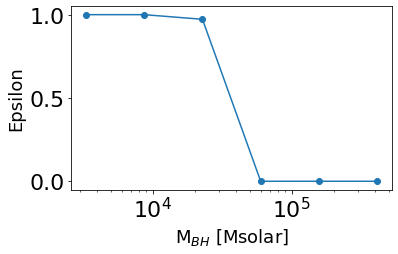

In [7]:
#Now plot the
#1. #Number of black holes at the start in each bin
#2. Overplot the number of black holes at the end

#Plot Epsilon against M_BH
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 18}

#matplotlib.rc('font', **font)
plt.rcParams.update({'font.size': 22})
plt.figure()
plt.semilogx(massbins, Epsilon, marker="o")
plt.xlabel("M$_{BH}$ [Msolar]", fontsize="18")
plt.ylabel("Epsilon", fontsize="18")
plt.tight_layout()
plt.savefig("EpsilonVsMass.pdf")

/home/regan/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/regan/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


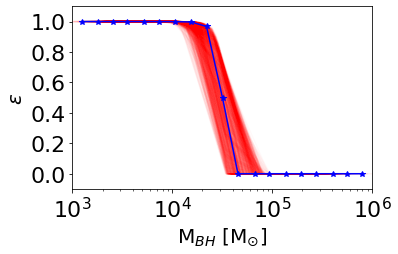

In [9]:
NUMBINS = 20
BinMasses = np.logspace(3, 6, NUMBINS)
Binned_Mass = {}
Binned_Epsilon = {}

for i in range(NUMBINS):
    Binned_Mass[i] = []
    Binned_Epsilon[i] = []
    
def delta_bin(m, e):
    for i in range(NUMBINS-1):
        if(m > BinMasses[i] and m < BinMasses[i+1]):
            if(e < 0.0):
                continue
            Binned_Mass[i].append(int(m))
            Binned_Epsilon[i].append(e)
            
#Ok let's run a MC simulation
#First up we need a normal distribution of heavy seed masses
np.random.seed(131180)
plt.figure()
for i in range(1000):
    #Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
    mu, sigma = 4.2, 0.45 # mean and standard deviation
    #mu, sigma = 4.9, 0.35 # mean and standard deviation
    s = np.random.normal(mu, sigma, 100)


    masses = np.power(10, s)
   
    #To do this I recreate the above histogram without normalising
    #and I divide into 6 bins
    count, bins, ignored = plt.hist(s, 6, density=False)
  
    massbins = np.power(10, bins[1::])
    DyTime = []
    Epsilon = []
    Masses = []

    for M_BH, Num_HeavySeeds in zip(massbins, count):
        M_BH = YTQuantity(M_BH, 'Msun')
        
        t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
        YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
        
        DyTime.append(t_df)
        new_radius = NewRadius(R_0, tau_hubble, t_df)
        N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

        N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

        #Total number of mergers in a Hubble Time
        #print("Total Number of Mergers in a Hubble Time = ", N_mm)
        N_mm =  min(Num_HeavySeeds, N_mm)
        epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
        Epsilon.append(epsilon.v)
        
       
        delta_bin(M_BH.v, epsilon.v)
 
    plt.semilogx(massbins, Epsilon, color='red', alpha=0.025)

FinalM = []
FinalE = []
for i in range(NUMBINS):
    FinalM.append(np.mean(np.asarray(Binned_Mass[i])))
    FinalE.append(np.mean(np.asarray(Binned_Epsilon[i])))
plt.semilogx(FinalM, FinalE, marker="*", color='blue')

plt.xlabel("M$_{BH}$ [M$_{\odot}$]", fontsize="20")
plt.ylabel("$\epsilon$", fontsize="20")
plt.xlim(1e3, 1e6)
plt.ylim(-0.1,1.1)
plt.yticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0))
plt.xticks((1e3, 1e4, 1e5, 1e6))
plt.tight_layout()
plt.savefig("EpsilonVsMass_MC.pdf")

